In [1]:
from typing import Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import AnyMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
from dotenv import load_dotenv
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [4]:
from langgraph.graph.message import add_messages

class ChatState(TypedDict):

    messages: Annotated[list[BaseMessage], add_messages]

In [5]:
def chat_node(state: ChatState):

    decision = interrupt({
        "type": "approval",
        "reason": "Model is about to answer a user question.",
        "question": state["messages"][-1].content,
        "instruction": "Approve this question? yes/no"
    })
    
    if decision["approved"] == 'no':
        return {"messages": [AIMessage(content="Not approved.")]}

    else:
        response = llm.invoke(state["messages"])
        return {"messages": [response]}



In [6]:
# 3. Build the graph: START -> chat -> END
builder = StateGraph(ChatState)

builder.add_node("chat", chat_node)

builder.add_edge(START, "chat")
builder.add_edge("chat", END)

# Checkpointer is required for interrupts
checkpointer = MemorySaver()

# Compile the app
app = builder.compile(checkpointer=checkpointer)

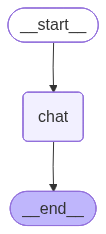

In [7]:
app

In [8]:
# Create a new thread id for this conversation
config = {"configurable": {"thread_id": '1234'}}

# ---- STEP 1: user asks a question ----
initial_input = {
    "messages": [
        ("user", "Explain gradient descent in very simple terms.")
    ]
}

# Invoke the graph for the first time
result = app.invoke(initial_input, config=config)

In [9]:
result

{'messages': [HumanMessage(content='Explain gradient descent in very simple terms.', additional_kwargs={}, response_metadata={}, id='8733bc89-25b3-41a4-8037-f85f86fe1363')],
 '__interrupt__': [Interrupt(value={'type': 'approval', 'reason': 'Model is about to answer a user question.', 'question': 'Explain gradient descent in very simple terms.', 'instruction': 'Approve this question? yes/no'}, id='225fa1667e506d9cb19ade971ba31364')]}

In [10]:
message = result['__interrupt__'][0].value
message

{'type': 'approval',
 'reason': 'Model is about to answer a user question.',
 'question': 'Explain gradient descent in very simple terms.',
 'instruction': 'Approve this question? yes/no'}

In [11]:
user_input = input(f"\nBackend message - {message} \n Approve this question? (y/n): ")

In [12]:
# Resume the graph with the approval decision
final_result = app.invoke(
    Command(resume={"approved": user_input}),
    config=config,
)

In [13]:
print(final_result["messages"][-1].content)

Imagine you're standing on a hill, and you want to get to the bottom. The problem is, it's foggy, and you can't see the entire hill. 

**Gradient Descent** is like taking small steps down the hill. Here's how it works:

1. You look around and see which direction is downhill (this is like calculating the "gradient" of the hill).
2. You take a small step in that direction (this is like updating your position).
3. You look around again and see which direction is still downhill.
4. You take another small step in that direction.
5. You keep doing this until you reach the bottom of the hill.

In machine learning, the "hill" is like a mathematical function that we want to minimize (e.g., an error function). The "steps" are like adjustments to the model's parameters. By iteratively taking small steps in the direction of the negative gradient (i.e., downhill), we can find the best parameters to minimize the error function.

That's gradient descent in a nutshell!
